In [ ]:
!pip install qucumber

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.cplx as cplx
import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

# set random seed on cpu but not gpu, since we won't use gpu for this tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)

The main difference between the previous tasks and the additional data provided is that in the first cases we tried to reconstruct the energy of the system from which we measured, while in the latter the reconstruction is of the original state from which the measurements were made.

In the following code we made a 4 qubit LiH state reconstruction by another method using the qucumber library and following the example with 2 qubits at the following link:

https://github.com/PIQuIL/QuCumber/blob/master/examples/Tutorial2_TrainComplexWaveFunction/tutorial_qubits.ipynb

# Reconstruction of a LiH

## The wavefunction to be reconstructed
The four qubits wavefunction below (coefficients stored in `LiH - psi.txt`) will be reconstructed.


$$\vert\psi \rangle = \alpha1 \vert0000\rangle + \beta1 \vert 0001\rangle + \gamma1 \vert0010\rangle + \delta1 \vert0011\rangle $$
+
$$\alpha2 \vert0100\rangle + \beta2 \vert 0101\rangle + \gamma2 \vert0110\rangle + \delta2 \vert0111\rangle$$
+
$$\alpha3 \vert1000\rangle + \beta3 \vert 1001\rangle + \gamma3 \vert1010\rangle + \delta3 \vert1011\rangle$$
+
$$\alpha4 \vert1100\rangle + \beta4 \vert 1101\rangle + \gamma4 \vert1110\rangle + \delta4 \vert1111\rangle$$

where 

$$
\alpha 1 = 4.9639 e-03
\beta 1 = -1.8227 e-16
\gamma 1 = 5.7627 e-02
\delta 1 = -1.1165 e-01
$$
;
$$
\alpha 2 = 3.2638 e-02 
\beta 2 = 2.4447 e-16 
\gamma 2 = -3.5453 e-02
\delta 2 = 5.7627 e-02
$$
;
$$
\alpha 3 = -8.1068 e-17
\beta 3 = 2.1391 e-16
\gamma 3 = -4.5975 e-16
\delta 3 = 7.6073 e-16
$$
;
$$
\alpha 4 = 9.8866 e-01
\beta 4 = 4.2995 e-16
\gamma 4 = 3.2638 e-02
\delta 4 = 4.9639 e-03
$$


The example dataset, `LiH - train_samples.txt`, comprises of 500 $\sigma$ measurements made in various bases (X, Y and Z). A corresponding file containing the bases for each data point in `LiH - train_samples.txt`, `LiH - train_bases.txt.txt`, is also required. As per convention, spins are represented in binary notation with zero and one denoting spin-down and spin-up, respectively.

## Using qucumber to reconstruct the wavefunction

The Python class `ComplexWaveFunction` contains generic properties of a RBM meant to reconstruct a complex wavefunction, the most notable one being the gradient function required for stochastic gradient descent.

To instantiate a `ComplexWaveFunction` object, one needs to specify the number of visible and hidden units in the RBM. The number of visible units, `num_visible`, is given by the size of the physical system, i.e. the number of spins or qubits (2 in this case), while the number of hidden units, `num_hidden`, can be varied to change the expressiveness of the neural network.

**Note:** The optimal `num_hidden` : `num_visible` ratio will depend on the system. For the two-qubit wavefunction described above, good results can be achieved when this ratio is 1.

On top of needing the number of visible and hidden units, a `ComplexWaveFunction` object requires the user to input a dictionary containing the unitary operators (2x2) that will be used to rotate the qubits in and out of the computational basis, Z, during the training process. The `unitaries` utility will take care of creating this dictionary.

The `MetricEvaluator` class and `training_statistics` utility are built-in amenities that will allow the user to evaluate the training in real time. 

Lastly, the `cplx` utility allows QuCumber to be able to handle complex numbers as they are not currently supported by PyTorch.


### Training
To evaluate the training in real time, the fidelity between the true wavefunction of the system and the wavefunction that QuCumber reconstructs, $\vert\langle\psi\vert\psi_{RBM}\rangle\vert^2$, will be calculated along with the Kullback-Leibler (KL) divergence (the RBM's cost function). First, the training data and the true wavefunction of this system need to be loaded using the `data` utility.

In [ ]:
train_path = "LiH - train_samples.txt"
train_bases_path = "LiH - train_bases.txt"
psi_path = "LiH - psi.txt"
bases_path = "LiH - qubit_bases.txt"

train_samples, true_psi, train_bases, bases = data.load_data(
    train_path, psi_path, train_bases_path, bases_path
)
train_samples = train_samples[0:10000,:]
train_bases = train_bases[0:10000,:]

In [ ]:
unitary_dict = unitaries.create_dict()

In [ ]:
nv = train_samples.shape[-1]
nh = nv

nn_state = ComplexWaveFunction(
    num_visible=nv, num_hidden=nh, unitary_dict=unitary_dict, gpu=True
)

In [ ]:
epochs = 500
pbs = 100  # pos_batch_size
nbs = pbs  # neg_batch_size
lr = 0.01
k = 10

In [ ]:
def alpha1(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    alpha_ = cplx.norm(
        torch.tensor([rbm_psi[0][0], rbm_psi[1][0]], device=nn_state.device)
        / normalization
    )
    return alpha_

def beta1(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    beta_ = cplx.norm(
        torch.tensor([rbm_psi[0][1], rbm_psi[1][1]], device=nn_state.device)
        / normalization
    )
    return beta_

def gamma1(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    gamma_ = cplx.norm(
        torch.tensor([rbm_psi[0][2], rbm_psi[1][2]], device=nn_state.device)
        / normalization
    )
    return gamma_

def delta1(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    delta_ = cplx.norm(
        torch.tensor([rbm_psi[0][3], rbm_psi[1][3]], device=nn_state.device)
        / normalization
    )
    return delta_

def alpha2(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    alpha_ = cplx.norm(
        torch.tensor([rbm_psi[0][4], rbm_psi[1][4]], device=nn_state.device)
        / normalization
    )
    return alpha_

def beta2(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    beta_ = cplx.norm(
        torch.tensor([rbm_psi[0][5], rbm_psi[1][5]], device=nn_state.device)
        / normalization
    )
    return beta_

def gamma2(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    gamma_ = cplx.norm(
        torch.tensor([rbm_psi[0][6], rbm_psi[1][6]], device=nn_state.device)
        / normalization
    )
    return gamma_

def delta2(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    delta_ = cplx.norm(
        torch.tensor([rbm_psi[0][7], rbm_psi[1][7]], device=nn_state.device)
        / normalization
    )
    return delta_

def alpha3(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    alpha_ = cplx.norm(
        torch.tensor([rbm_psi[0][8], rbm_psi[1][8]], device=nn_state.device)
        / normalization
    )
    return alpha_

def beta3(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    beta_ = cplx.norm(
        torch.tensor([rbm_psi[0][9], rbm_psi[1][9]], device=nn_state.device)
        / normalization
    )
    return beta_

def gamma3(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    gamma_ = cplx.norm(
        torch.tensor([rbm_psi[0][10], rbm_psi[1][10]], device=nn_state.device)
        / normalization
    )
    return gamma_

def delta3(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    delta_ = cplx.norm(
        torch.tensor([rbm_psi[0][11], rbm_psi[1][11]], device=nn_state.device)
        / normalization
    )
    return delta_

def alpha4(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    alpha_ = cplx.norm(
        torch.tensor([rbm_psi[0][12], rbm_psi[1][12]], device=nn_state.device)
        / normalization
    )
    return alpha_

def beta4(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    beta_ = cplx.norm(
        torch.tensor([rbm_psi[0][13], rbm_psi[1][13]], device=nn_state.device)
        / normalization
    )
    return beta_

def gamma4(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    gamma_ = cplx.norm(
        torch.tensor([rbm_psi[0][14], rbm_psi[1][14]], device=nn_state.device)
        / normalization
    )
    return gamma_

def delta4(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    delta_ = cplx.norm(
        torch.tensor([rbm_psi[0][15], rbm_psi[1][15]], device=nn_state.device)
        / normalization
    )
    return delta_

In [ ]:
period = 25
space = nn_state.generate_hilbert_space()

callbacks = [
    MetricEvaluator(
        period,
        {
            "Fidelity": ts.fidelity,
            "KL": ts.KL,
            #"normα1": alpha1,
            # "normβ1": beta1,
            # "normγ1": gamma1,
             "normδ1": delta1,
            #"normα2": alpha2,
            # "normβ2": beta2,
            # "normγ2": gamma2,
            # "normδ2": delta2,
            #"normα3": alpha3,
            # "normβ3": beta3,
            # "normγ3": gamma3,
            # "normδ3": delta3,
            #"normα4": alpha4,
            # "normβ4": beta4,
            # "normγ4": gamma4,
            # "normδ4": delta4,
        },
        target=true_psi,
        bases=bases,
        verbose=True,
        space=space,
    )
]

In [ ]:
nn_state.fit(
    train_samples,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    input_bases=train_bases,
    callbacks=callbacks,
    time=True,
)

Epoch: 25	Fidelity = 0.988816	KL = 0.018485	normδ1 = 0.049166
Epoch: 50	Fidelity = 0.989124	KL = 0.017387	normδ1 = 0.051310
Epoch: 75	Fidelity = 0.988866	KL = 0.018251	normδ1 = 0.049598
Epoch: 100	Fidelity = 0.989057	KL = 0.017556	normδ1 = 0.050961
Epoch: 125	Fidelity = 0.988502	KL = 0.019496	normδ1 = 0.047261
Epoch: 150	Fidelity = 0.988563	KL = 0.019168	normδ1 = 0.047829
Epoch: 175	Fidelity = 0.988365	KL = 0.019886	normδ1 = 0.046529
Epoch: 200	Fidelity = 0.988096	KL = 0.020849	normδ1 = 0.044850
Epoch: 225	Fidelity = 0.987915	KL = 0.021445	normδ1 = 0.043841
Epoch: 250	Fidelity = 0.987473	KL = 0.023018	normδ1 = 0.041332
Epoch: 275	Fidelity = 0.988114	KL = 0.020473	normδ1 = 0.045426
Epoch: 300	Fidelity = 0.987972	KL = 0.020983	normδ1 = 0.044578
Epoch: 325	Fidelity = 0.987778	KL = 0.021682	normδ1 = 0.043431
Epoch: 350	Fidelity = 0.987980	KL = 0.020872	normδ1 = 0.044772
Epoch: 375	Fidelity = 0.987748	KL = 0.021740	normδ1 = 0.043340
Epoch: 400	Fidelity = 0.987912	KL = 0.021060	normδ1 = 0.04

In [ ]:
fidelities = callbacks[0].Fidelity
KLs = callbacks[0]["KL"]
coeffs = callbacks[0]["normδ1"]
epoch = np.arange(period, epochs + 1, period)

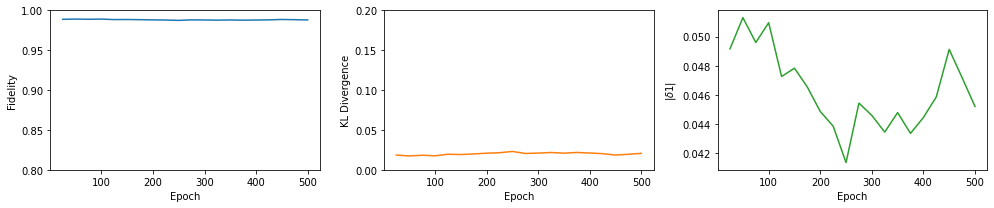

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))

ax = axs[0]
ax.plot(epoch, fidelities, color="C0", markeredgecolor="black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")
ax.set_ylim([0.8,1])

ax = axs[1]
ax.plot(epoch, KLs, color="C1", markeredgecolor="black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")
ax.set_ylim([0,0.2])

ax = axs[2]
ax.plot(epoch, coeffs, color="C2", markeredgecolor="black")
ax.set_ylabel(r"$\vert\delta 1\vert$")
ax.set_xlabel(r"Epoch")
#ax.set_ylim([0.01,0.03])

plt.tight_layout()
plt.show()